In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq self-supervised

In [ ]:
#default_exp vision.dino

# MAE

> MAE: [Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/pdf/2111.06377v1.pdf)

In [ ]:
# !pip install transformers

In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.models.vision_transformer import *

## Algorithm

#### MAE

![MAE Framework](images/mae.png)

**Abstract**: This paper shows that masked autoencoders (MAE) are
scalable self-supervised learners for computer vision. Our
MAE approach is simple: we mask random patches of the
input image and reconstruct the missing pixels. It is based
on two core designs. First, we develop an asymmetric
encoder-decoder architecture, with an encoder that operates only on the visible subset of patches (without mask tokens), along with a lightweight decoder that reconstructs
the original image from the latent representation and mask
tokens. Second, we find that masking a high proportion
of the input image, e.g., 75%, yields a nontrivial and
meaningful self-supervisory task. Coupling these two designs enables us to train large models efficiently and effectively: we accelerate training (by 3× or more) and improve accuracy. Our scalable approach allows for learning
high-capacity models that generalize well: e.g., a vanilla
ViT-Huge model achieves the best accuracy (87.8%) among
methods that use only ImageNet-1K data. Transfer performance in downstream tasks outperforms supervised pretraining and shows promising scaling behavior

**Own Summary**:

In [ ]:
import timm

In [ ]:
def get_dls(size, bs, workers=None, n_subset=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    if n_subset is None: files = get_image_files(source)
    else:              files = np.random.choice(get_image_files(source), n_subset)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [ ]:
bs, resize, size = 4, 224, 224

In [ ]:
dls = get_dls(resize, bs, n_subset=1000)

In [ ]:
xb,yb = dls.train.one_batch()

In [ ]:
dls.c

21

In [ ]:
xb.shape, yb.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

In [ ]:
timm.list_models("*vit_base*")

['convit_base',
 'vit_base_patch16_224',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_384',
 'vit_base_patch32_224',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_384',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224']

In [ ]:
mask_ratio = 0.75
emb_size = 768

In [ ]:
mask_emb = Embedding(1,emb_size)

In [ ]:
encoder = create_timm_encoder("vit_base_patch16_224", pretrained=False).cuda()

In [ ]:
encoder.forward_features??

Signature: encoder.forward_features(x)
Docstring: <no docstring>
Source:   
    def forward_features(self, x):
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]
File:      /usr/local/lib/python3.6/dist-packages/timm/models/vision_transformer.py
Type:      method


In [ ]:
# remove cls token
encoder.pos_embed.data = encoder.pos_embed.data[:,:-1]

In [ ]:
x = encoder.patch_embed(xb) + encoder.pos_embed

In [ ]:
bs = x.size(0)
n_tokens = x.size(1)
n_encoder_tokens = int(n_tokens*(1-mask_ratio))

In [ ]:
patch_size = int(xb.size(2)//np.sqrt(n_tokens))

In [ ]:
n_tokens, n_encoder_tokens, patch_size

(196, 49, 16)

In [ ]:
shuffle_idxs = torch.stack([torch.randperm(n_tokens) for i in range(bs)])

In [ ]:
reshuffle_idxs = torch.argsort(shuffle_idxs)

In [ ]:
def shuffle_reshuffle_test():
    "Shuffle before encoder and reshuffle before decoder"
    x = torch.rand(2,3,4); x, x.shape
    shuffle_idxs = tensor([[2,1,0], [1,0,2]]); shuffle_idxs, shuffle_idxs.shape
    shuffled_x = torch.stack([x[i,idxs] for i,idxs in enumerate(shuffle_idxs)])

    reshuffle_idxs = torch.argsort(shuffle_idxs)
    reshuffled_x = torch.stack([shuffled_x[i,idxs] for i,idxs in enumerate(reshuffle_idxs)])
    
    torch.equal(x,reshuffled_x)

In [ ]:
shuffled_x = torch.stack([x[i,idxs] for i,idxs in enumerate(shuffle_idxs)])

In [ ]:
shuffled_x = shuffled_x[:,:n_encoder_tokens]

In [ ]:
shuffled_x.shape

torch.Size([4, 49, 768])

In [ ]:
x = encoder.norm(encoder.blocks(shuffled_x))

In [ ]:
mask_x = mask_emb(torch.zeros((bs,n_tokens-n_encoder_tokens), dtype=torch.long)).to(x)

In [ ]:
x.shape, mask_x.shape

(torch.Size([4, 49, 768]), torch.Size([4, 147, 768]))

In [ ]:
x = torch.cat([x,mask_x], dim=1)

In [ ]:
reshuffled_x = torch.stack([x[i,idxs] for i,idxs in enumerate(reshuffle_idxs)])

In [ ]:
reshuffled_x = reshuffled_x + encoder.pos_embed 

In [ ]:
decoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=emb_size, nhead=8, batch_first=True), num_layers=4).cuda()

In [ ]:
x = decoder(reshuffled_x)

/usr/local/lib/python3.6/dist-packages/torch/overrides.py:1351: DeprecationWarning: Defining your `__torch_function__ as a plain method is deprecated and will be an error in PyTorch 1.11, please define it as a classmethod.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/torch/overrides.py:1351: DeprecationWarning: Defining your `__torch_function__ as a plain method is deprecated and will be an error in PyTorch 1.11, please define it as a classmethod.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/torch/overrides.py:1351: DeprecationWarning: Defining your `__torch_function__ as a plain method is deprecated and will be an error in PyTorch 1.11, please define it as a classmethod.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/torch/overrides.py:1351: DeprecationWarning: Defining your `__torch_function__ as a plain method is deprecated and will be an error in PyTorch 1.11, please define it as a classmethod.
  DeprecationWarning)
/usr/local/lib/pytho

In [ ]:
x.shape

torch.Size([4, 196, 768])

In [ ]:
fc = nn.Linear(emb_size, patch_size**2).cuda()

In [ ]:
x = fc(x)

/usr/local/lib/python3.6/dist-packages/torch/overrides.py:1351: DeprecationWarning: Defining your `__torch_function__ as a plain method is deprecated and will be an error in PyTorch 1.11, please define it as a classmethod.
  DeprecationWarning)


In [ ]:
x.shape

torch.Size([4, 196, 256])

In [ ]:
xb.shape

torch.Size([4, 3, 224, 224])

In [ ]:
targ_idxs = shuffle_idxs[:,n_encoder_tokens:]

In [ ]:
targ_idxs

tensor([[  9, 158, 135,  87,  83, 133, 134, 190, 194, 118,  29, 167, 126,  78,
          42,  84,  25, 157,  97, 195,  88,  38, 139,  10,   3, 121, 188, 170,
          12,  94,  50,  75,  22,  86, 143, 130,  98,  85, 125, 145, 105, 181,
           8, 102, 115,  11, 147,  57,  17,  15, 171,  63,  19, 151, 108, 128,
          18,  41,  72, 131,  24, 116,  28,  91, 169, 166,  99, 129, 163,  67,
          40, 146, 183,   4, 104,   5,  70,  20,  81,   2, 192,  96, 110, 150,
          55, 112, 175, 137,  65,  23,   7,  36, 189, 111, 165, 185, 124,  79,
          54, 160, 174,  66, 144, 117,  89,  64, 164,  47, 187, 184,  48,  21,
          69,  52, 155, 193, 186,  68,  51, 122,  56, 168,  59, 148, 176, 123,
           6,  76, 178, 154,  93,  33, 180,  31,  27,  26,  49, 149,  53,  80,
         109,  14, 119,  61,   1,  30, 103],
        [128, 111, 182,  17,  27,  47, 125,  87, 172,  90,  29, 186, 114, 118,
           1, 190, 145,  75, 116, 121, 155, 181,  74,  13,  96,  65,  68,  69,
       

In [ ]:
#export
class DINOHead(nn.Module):
    '''
    copy.deepcopy:
    RuntimeError: Only Tensors created explicitly by the user (graph leaves) 
    support the deepcopy protocol at the moment
    
    https://pytorch.org/docs/stable/generated/torch.nn.utils.weight_norm.html
    https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
    '''
    def __init__(self, in_dim, out_dim, use_bn=False, norm_last_layer=True, nlayers=3, hidden_dim=2048, bottleneck_dim=256):
        super().__init__()
        nlayers = max(nlayers, 1)
        if nlayers == 1:
            self.mlp = nn.Linear(in_dim, bottleneck_dim)
        else:
            layers = [nn.Linear(in_dim, hidden_dim)]
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.GELU())
            for _ in range(nlayers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                if use_bn:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                layers.append(nn.GELU())
            layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            self.mlp = nn.Sequential(*layers)
        self.apply(self._init_weights)
        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1)
        if norm_last_layer:
            self.last_layer.weight_g.requires_grad = False

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.mlp(x)
        x = nn.functional.normalize(x, dim=-1, p=2)
        x = self.last_layer(x)
        return x

In [ ]:
#export
@delegates(get_multi_aug_pipelines, but=['n', 'size', 'resize_scale'])
def get_dino_aug_pipelines(num_crops=(2,4), crop_sizes=(224,96), min_scales=(0.4,0.05), max_scales=(1.,0.4), **kwargs): 
    aug_pipelines = []
    for nc, size, mins, maxs in zip(num_crops, crop_sizes, min_scales, max_scales):
        aug_pipelines += get_multi_aug_pipelines(n=nc, size=size, resize_scale=(mins,maxs), **kwargs)
    return aug_pipelines

In [ ]:
aug_pipelines = get_dino_aug_pipelines()

In [ ]:
#export
class DINOModel(Module):
    def __init__(self, student, teacher):
        "A module for loading and saving all training params together"
        self.student,self.teacher = student,teacher
        self.teacher.load_state_dict(student.state_dict())
        for p in self.teacher.parameters(): p.requires_grad = False 
        self.register_buffer('C',  torch.zeros(1,num_features_model(teacher)))            
    def forward(self,x): return self.student(x)

In [ ]:
bs = 4
x_large = [torch.randn(4,3,224,224)]*2
x_small = [torch.randn(4,3,96,96)]*4

In [ ]:
deits16 = deit_small(patch_size=16, drop_path_rate=0.1)
deits16 = MultiCropWrapper(deits16)
dino_head = DINOHead(deits16.encoder.embed_dim, 2**16, norm_last_layer=True)
student_model = nn.Sequential(deits16,dino_head)

deits16 = deit_small(patch_size=16)
deits16 = MultiCropWrapper(deits16)
dino_head = DINOHead(deits16.encoder.embed_dim, 2**16, norm_last_layer=True)
teacher_model = nn.Sequential(deits16,dino_head)

dino_model = DINOModel(student_model, teacher_model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [ ]:
dino_model.student[1]

DINOHead(
  (mlp): Sequential(
    (0): Linear(in_features=384, out_features=2048, bias=True)
    (1): GELU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): GELU()
    (4): Linear(in_features=2048, out_features=256, bias=True)
  )
  (last_layer): Linear(in_features=256, out_features=65536, bias=False)
)

In [ ]:
#export
class DINO(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, large_crop_ids=[0,1],
                         cmom=0.9, 
                         tmom_start=0.996, tmom_end=1., tmom_sched=SchedCos,
                         tpt_start=0.04, tpt_end=0.04, tpt_warmup_pct=0., tpt_sched=SchedLin, 
                         tps=0.1,
                         freeze_last_layer=1,
                         print_augs=False):
        """
        DINO teacher student training with distillation.
        Refer to original repo: 
        https://github.com/facebookresearch/dino/blob/0be6e112dd579203caaa1d0f066e29ca536f76dd/main_dino.py#L41
            cmom:           Center update momentum.
            tmom:           Teacher update momentum. Set larger, e.g. 0.9995, for small batches or 0.996 for large batches (256+).
            tpt_warmup:     Warm up starting temperature
            tpt_warmup_pct: Percentage of training for warmup
            tpt_sched:      Warm up scheduler, e.g. SchedLin, SchedCos, SchedExp
            tpt:            Teacher temperature after warm up. Decrease if training loss does not decrease.
                            Smaller temperature means more sharpening.
            tps:            Student temperature.
            freeze_last_layer: How many epochs to freeze the last layer
        """
        store_attr('large_crop_ids,cmom,freeze_last_layer,tps')
        self.augs = aug_pipelines
        self.tpt_scheduler  = combine_scheds([tpt_warmup_pct,1-tpt_warmup_pct], 
                                             [tpt_sched(tpt_start,tpt_end),SchedNo(tpt_end,tpt_end)])
        self.tmom_scheduler = tmom_sched(tmom_start, tmom_end)
        if print_augs: 
            for aug in self.augs: print(aug)
    
    
    def before_fit(self):
        "Create teacher model as a copy of student"
        self.learn.loss_func = self.lf        
        self.tpt  = self.tpt_scheduler(0.)
        self.tmom = self.tmom_scheduler(0.)
        self.model.teacher.eval()
        
        for n,p in self.learn.model.student[1].last_layer.named_parameters(): 
            if n == 'weight_v' : p.requires_grad = False
    
    
    def before_batch(self):
        "Augment multi crop views"
        self.bs = self.x.size(0)
        self.learn.xb = ([aug(self.x) for aug in self.augs],)
        x_large = [self.learn.xb[0][i] for i in self.large_crop_ids]
        
        # TODO: Do we need to put the teacher in eval(), not it original repo?
        with torch.no_grad():
            targs = self.model.teacher(x_large)
            self.learn.yb = (targs,)
            self.cb       = targs.mean(0, keepdim=True)

            
    def _momentum_update_teacher(self):
        for param_s, param_t in zip(self.learn.model.student.parameters(), self.model.teacher.parameters()):
            param_t.data = param_t.data * self.tmom + param_s.data * (1. - self.tmom)

            
    def _momentum_update_center(self):
        self.model.C = self.model.C*self.cmom + self.cb*(1-self.cmom)
            
            
    def after_step(self):
        "Center and teacher updates"
        self._momentum_update_teacher(); self._momentum_update_center()
    
    
    def after_epoch(self):
        "Update tpt at the end of each epoch"
        self.tpt  = self.tpt_scheduler(self.pct_train)
        self.tmom = self.tmom_scheduler(self.pct_train)
        
        if self.epoch == self.freeze_last_layer:
            print("Setting last layer to trainable")
            for n,p in self.learn.model.student[1].last_layer.named_parameters(): 
                if n == 'weight_v' : p.requires_grad = True

                
    def lf(self, pred, *yb):
        "Multi crop cross entropy loss: -qlog(p)"
        yb = yb[0]
        pred = F.log_softmax(pred / self.tps, dim=-1)
        yb   = F.softmax((yb - self.model.C) / self.tpt, dim=-1)
        
        n_targs, n_preds = yb.size(0)//self.bs, pred.size(0)//self.bs
        yb, pred = yb.chunk(n_targs), pred.chunk(n_preds)

        loss, npairs = 0, n_targs*(n_preds-1) 
        for ti in range(n_targs):
            for pi in range(n_preds):
                if ti != pi:
                    loss += (-yb[ti]*pred[pi]).sum(-1).mean() / npairs
        return loss
    
    
            
    @torch.no_grad()
    def show(self, n=1):
        xbs = self.learn.xb[0]
        idxs = np.random.choice(range(self.bs), n, False)
        images = [aug.decode(xb.to('cpu').clone()).clamp(0, 1)[i] 
                  for i in idxs
                  for xb, aug in zip(xbs, self.augs)]
        return show_batch(images[0], None, images, max_n=len(images), nrows=n)

Training schedule for DINO

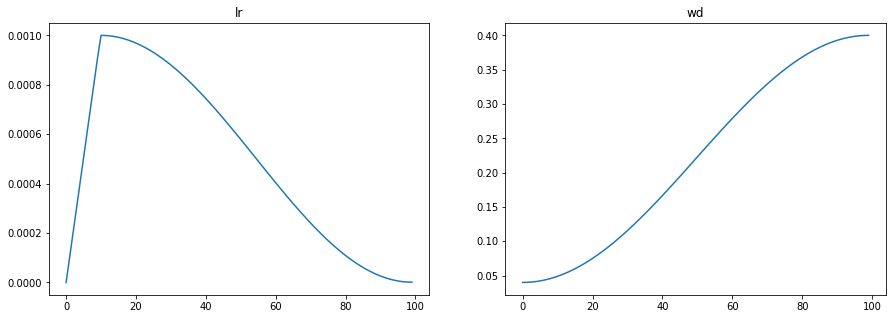

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
lr_sched = combine_scheds([0.1,0.9], [SchedLin(0.,1e-3), SchedCos(1e-3,1e-6)])
ax[0].plot([lr_sched(i) for i in np.linspace(0,1,100)]);ax[0].set_title('lr')
wd_sched = SchedCos(0.04,0.4)
ax[1].plot([wd_sched(i) for i in np.linspace(0,1,100)]);ax[1].set_title('wd');

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01 - augmentations.ipynb.
Converted 02 - layers.ipynb.
Converted 03 - distributed.ipynb.
Converted 10 - simclr.ipynb.
Converted 11 - moco.ipynb.
Converted 12 - byol.ipynb.
Converted 13 - swav.ipynb.
Converted 14 - barlow_twins.ipynb.
Converted 15 - dino.ipynb.
Converted 20 - clip.ipynb.
Converted 21 - clip-moco.ipynb.
Converted 70 - vision.metrics.ipynb.
Converted 90 - models.vision_transformer.ipynb.
Converted index.ipynb.
